In [ ]:
!pip install rasterio
!pip install xarray
!pip install contextily

In [185]:
import pandas as pd

# prevent false warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import numpy as np

import geopandas
from geopandas import GeoSeries

import contextily as cx

from shapely.geometry import Polygon
from shapely import wkt

import rasterio

In [148]:
# https://stackoverflow.com/questions/67487713/python-how-to-convert-geotiff-to-geopandas

# ATTENTION: for first try (District_N_Wete) one None-Value got mixed up to -99999 (instead of -9999)
# to the legend was way off. Below check `if colval >= 0:` was added to prevent this.
# No investigation why this error occured yet...

import affine
import geopandas as gpd
import rasterio.features
import xarray as xr
import shapely.geometry as sg


def polygonize(da: xr.DataArray) -> gpd.GeoDataFrame:
    """
    Polygonize a 2D-DataArray into a GeoDataFrame of polygons.

    Parameters
    ----------
    da : xr.DataArray

    Returns
    -------
    polygonized : geopandas.GeoDataFrame
    """
    if da.dims != ("y", "x"):
        raise ValueError('Dimensions must be ("y", "x")')

    values = da.values
    transform = da.attrs.get("transform", None)
    if transform is None:
        raise ValueError("transform is required in da.attrs")
    transform = affine.Affine(*transform)
    shapes = rasterio.features.shapes(values, transform=transform)

    geometries = []
    colvalues = []
    for (geom, colval) in shapes:
        
        if colval >= 0:
            geometries.append(sg.Polygon(geom["coordinates"][0]))
            colvalues.append(colval)

    gdf = gpd.GeoDataFrame({"value": colvalues, "geometry": geometries})
    gdf.crs = da.attrs.get("crs")
    return gdf

In [162]:
DISTRICT='District_N_Temeke'

In [163]:
dataset = rasterio.open('./output/{}/worldpop/tza_ppp_2020_UNadj.tiff'.format(DISTRICT))

In [164]:
print("wxh: {} x {} (bands: {})".format(dataset.width, dataset.height, dataset.count))

wxh: 432 x 438 (bands: 1)


In [165]:
dataset.bounds

BoundingBox(left=39.19208319166422, bottom=-7.178749769718799, right=39.55208319022876, top=-6.813749771188294)

In [166]:
dataset.crs

CRS.from_epsg(4326)

In [167]:
band1 = dataset.read(1)

In [168]:
band1

array([[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       ...,
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],
      dtype=float32)

In [169]:
# build sum of all not Non-Values
s = 0
m = []
for y in range(len(band1)):
    for x in range(len(band1[y])):
        if band1[y][x] != -99999:
            s += band1[y][x]
            m.append(band1[y][x])
print(s)

2335534.4870314673


In [170]:
district_gdf = geopandas.read_file('Districts/{}.shp'.format(DISTRICT))

In [171]:
district_gdf

,District_C,District_N,geometry
0,03,Temeke,"POLYGON ((39.31406 -6.81318, 39.31429 -6.81319..."


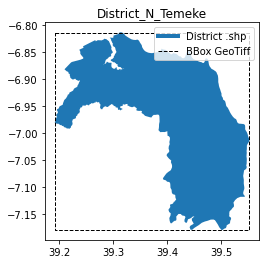

In [197]:
ax = district_gdf.plot(legend=True, label='District_N')

# cerate polygon from bbox of GeoTiff vor validation
bb = Polygon([(dataset.bounds.left, dataset.bounds.top), (dataset.bounds.right, dataset.bounds.top), 
              (dataset.bounds.right, dataset.bounds.bottom), (dataset.bounds.left, dataset.bounds.bottom)])
g = GeoSeries([bb])
g.plot(ax=ax, edgecolor="black", linestyle='--', facecolor="none", alpha=1, label="BBox GeoTiff")


plt.title(DISTRICT)

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='black', linestyle='--', lw=1)]

plt.legend(custom_lines, ['District .shp', "BBox GeoTiff"])

plt.show()

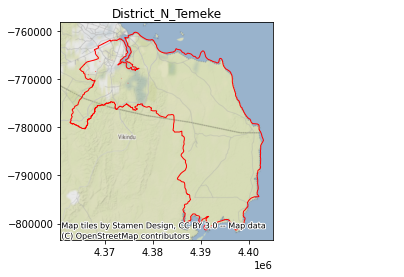

In [207]:
# web mercator for background


district_gdf_wm = district_gdf.to_crs(epsg=3857)
#g_wm = g.to_crs(epsg=3857)


ax = district_gdf_wm.plot(legend=True, edgecolor="red", alpha=1, color='none')

#g_wm.plot(ax=ax, edgecolor="black", linestyle='--', facecolor="none", alpha=1, label="BBox GeoTiff")


plt.title(DISTRICT)

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='black', linestyle='--', lw=1)]

#plt.legend(custom_lines, ['District .shp', "BBox GeoTiff"])

cx.add_basemap(ax)

plt.show()


In [176]:
# convert Raster GeoTiff to "list" of polygons for Vector Chart in Geopandas
urbanData = xr.open_rasterio('./output/{}/worldpop/tza_ppp_2020_UNadj.tiff'.format(DISTRICT)).squeeze('band', drop=True)
test_gdf = polygonize(urbanData)

/var/folders/zd/y3rzdn112y7g2ssx_h76r_4m0000gn/T/ipykernel_87497/2388559937.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  urbanData = xr.open_rasterio('./output/{}/worldpop/tza_ppp_2020_UNadj.tiff'.format(DISTRICT)).squeeze('band', drop=True)
/opt/homebrew/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


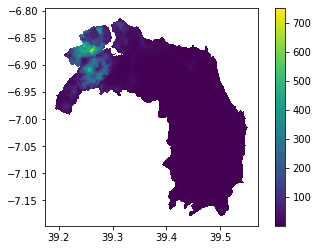

In [192]:
test_gdf.plot(column="value", legend=True)

plt.show()

In [175]:
test_gdf['value'].max()

203.62864685058594

In [183]:
test_gdf.at[10000, 'geometry'].wkt

'POLYGON ((39.314583191175764 -6.874583104276711, 39.314583191175764 -6.87541643760669, 39.31541652450577 -6.87541643760669, 39.31541652450577 -6.874583104276711, 39.314583191175764 -6.874583104276711))'

<AxesSubplot:>

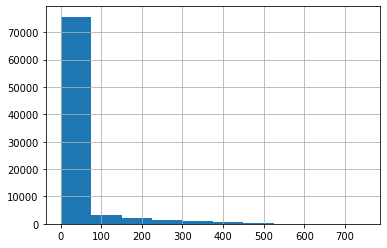

In [209]:
test_gdf['value'].hist()